In [1]:
import os
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
from matplotlib import pylab as plt

import optuna

In [2]:
token = os.environ['oanda_access_token']
account = os.environ['oanda_account_id']

In [3]:
from my_oanda.my_oanda import Bot

In [4]:
class MyBot(Bot):
    def set_param(self, a, b, c, d, stop_loss, take_profit):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        self.params = {"a":a, "b":b, "c":c, "d":d, "stop_loss":stop_loss, "take_profit":take_profit}
        
    def atr(self, *, period: int = 14, price: str = "C"):
        a = (self.df.H - self.df.L).abs()
        b = (self.df.H - self.df[price].shift()).abs()
        c = (self.df.L - self.df[price].shift()).abs()

        df = pd.concat([a, b, c], axis=1).max(axis=1)
        return df.ewm(span=period).mean()
        
    def strategy(self):
        rsi = self.rsi(period=self.a)
        ema = self.ema(period=self.b)
        atr = self.atr(period=self.c)
        lower = ema - atr
        upper = ema + atr
        self.buy_entry = (rsi < self.d )& (self.df.C < lower)
        self.sell_entry = (rsi > 100-self.d) & (self.df.C > upper)
        self.sell_exit = ema > self.df.C
        self.buy_exit = ema < self.df.C


In [5]:
start = "2020-1-1"
end = "2020-12-31"
glan = "M2"
inst = "USD_JPY"

In [6]:
mybot = MyBot(
    account_id=account,
    access_token=token,
    environment='live',
    instrument=inst,
    granularity=glan, # 15 second candlestick,
    folder = "../data/"
)

In [7]:
def objective(trial):
    a = trial.suggest_int('a', 5, 50)
    b = trial.suggest_int('b', 5, 50)
    c = trial.suggest_int('c', 5, 50)
    d = trial.suggest_int('d', 20, 40)
    
    sl = trial.suggest_int('stop_loss', 5, 50)
    tp = trial.suggest_int('take_profit', 5, 50)
    
    mybot.set_param(a, b, c, d, sl, tp)
    
    score =  -mybot.backtest(from_date=start, to_date=end)['total profit']
#     print('a: %d, b: %d, score: %1.2f' % (a, b, -score))
    return score

In [8]:
study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2021-02-21 09:41:26,866] A new study created in memory with name: no-name-332f1f8a-40dd-4312-93b5-af0f56142ece
[I 2021-02-21 09:41:27,743] Trial 0 finished with value: -46310.0 and parameters: {'a': 47, 'b': 6, 'c': 19, 'd': 38, 'stop_loss': 14, 'take_profit': 41}. Best is trial 0 with value: -46310.0.
[I 2021-02-21 09:41:28,601] Trial 1 finished with value: -55440.0 and parameters: {'a': 24, 'b': 39, 'c': 34, 'd': 24, 'stop_loss': 14, 'take_profit': 30}. Best is trial 1 with value: -55440.0.
[I 2021-02-21 09:41:29,646] Trial 2 finished with value: -140830.0 and parameters: {'a': 6, 'b': 23, 'c': 43, 'd': 24, 'stop_loss': 41, 'take_profit': 41}. Best is trial 2 with value: -140830.0.
[I 2021-02-21 09:41:30,488] Trial 3 finished with value: -36750.0 and parameters: {'a': 26, 'b': 23, 'c': 44, 'd': 20, 'stop_loss': 30, 'take_profit': 20}. Best is trial 2 with value: -140830.0.
[I 2021-02-21 09:41:31,337] Trial 4 finished with value: -68980.0 and parameters: {'a': 50, 'b': 23, 'c': 48,

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [17]:
study.trials[0].values[0]

-46310.0

In [9]:
params=study.best_trial.params

In [10]:
params

{'a': 18, 'b': 34, 'c': 37, 'd': 36, 'stop_loss': 5, 'take_profit': 47}

In [11]:
mybot.set_param(params['a'], params['b'], params['c'], params['d'], params['stop_loss'], params['take_profit'])

total profit                                                 275510.0
total trades                                                   9766.0
win rate                                                       53.963
profit factor                                                   1.117
maximum drawdown                                              24550.0
recovery factor                                                11.222
riskreward ratio                                                 1.03
sharpe ratio                                                    0.043
average return                                                 25.419
stop loss                                                      4673.0
take profit                                                      16.0
params              {'a': 18, 'b': 34, 'c': 37, 'd': 36, 'stop_los...
dtype: object


total profit                                                 275510.0
total trades                                                   9766.0
win rate                                                       53.963
profit factor                                                   1.117
maximum drawdown                                              24550.0
recovery factor                                                11.222
riskreward ratio                                                 1.03
sharpe ratio                                                    0.043
average return                                                 25.419
stop loss                                                      4673.0
take profit                                                      16.0
params              {'a': 18, 'b': 34, 'c': 37, 'd': 36, 'stop_los...
dtype: object

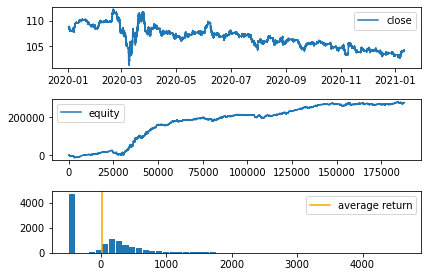

In [12]:
mybot.backtest(from_date=start, to_date=end, filename="hogebacktest.png", show=True)

total profit                                                  11910.0
total trades                                                   1095.0
win rate                                                       60.913
profit factor                                                   1.061
maximum drawdown                                              12870.0
recovery factor                                                 0.925
riskreward ratio                                                0.684
sharpe ratio                                                    0.025
average return                                                 10.326
stop loss                                                       388.0
take profit                                                       0.0
params              {'a': 18, 'b': 34, 'c': 37, 'd': 36, 'stop_los...
dtype: object


total profit                                                  11910.0
total trades                                                   1095.0
win rate                                                       60.913
profit factor                                                   1.061
maximum drawdown                                              12870.0
recovery factor                                                 0.925
riskreward ratio                                                0.684
sharpe ratio                                                    0.025
average return                                                 10.326
stop loss                                                       388.0
take profit                                                       0.0
params              {'a': 18, 'b': 34, 'c': 37, 'd': 36, 'stop_los...
dtype: object

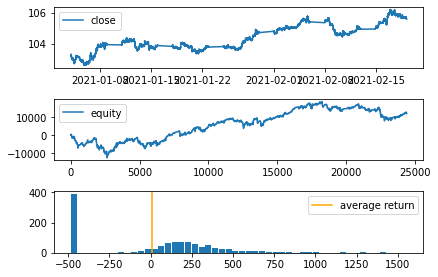

In [13]:
start_rev = "2021-1-1"
end_rev = "2021-2-19"
mybot.backtest(from_date=start_rev, to_date=end_rev, filename="hogebacktest.png", show=True)

In [ ]:
#total profit        14490.000